# Intestinal organoid differentiation - RNA velocity with EM model

Estimates RNA velocity with scVelo's _EM model_ and analyses corresponding fate mapping.

## Library imports

In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

from cr2 import get_state_purity, get_var_ranks, plot_state_purity, running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [3]:
scv.settings.set_figure_params("scvelo")

In [4]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    (FIG_DIR / "labeling_kernel").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "sceu_organoid" / "results").mkdir(parents=True, exist_ok=True)

## Constants

In [6]:
N_JOBS = 8

## Data loading

In [7]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "raw.h5ad")

adata = adata[adata.obs["labeling_time"] != "dmso", :].copy()
adata = adata[~adata.obs["cell_type"].isin(["Tuft cells"]), :]
adata.obs["labeling_time"] = adata.obs["labeling_time"].astype(float) / 60

adata.layers["unspliced"] = adata.layers["unlabeled_unspliced"] + adata.layers["labeled_unspliced"]
adata.layers["spliced"] = adata.layers["unlabeled_spliced"] + adata.layers["labeled_spliced"]

umap_coord_df = pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "umap_coords.csv", index_col=0)
umap_coord_df.index = umap_coord_df.index.astype(str)
adata.obsm["X_umap"] = umap_coord_df.loc[adata.obs_names, :].values
del umap_coord_df

adata

/tmp/ipykernel_1102372/2797837506.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["labeling_time"] = adata.obs["labeling_time"].astype(float) / 60


AnnData object with n_obs × n_vars = 3452 × 9157
    obs: 'experiment', 'labeling_time', 'cell_type', 'well_id', 'batch_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime'
    var: 'ensum_id'
    uns: 'cell_type_colors'
    obsm: 'X_umap_paper', 'X_umap'
    layers: 'labeled', 'labeled_spliced', 'labeled_unspliced', 'total', 'unlabeled', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

## Data preprocessing

In [8]:
adata.obs["cell_type_merged"] = adata.obs["cell_type"].copy()
adata.obs["cell_type_merged"].replace({"Enteroendocrine cells": "Enteroendocrine progenitors"}, inplace=True)

In [9]:
# filter s.t. at least `min_counts` per labeling time point?
scv.pp.filter_and_normalize(
    adata,
    min_counts=50,
    layers_normalize=["X", "labeled", "unlabeled", "total", "unspliced", "spliced"],
    n_top_genes=2000,
)
adata

Filtered out 736 genes that are detected 50 counts (spliced).
Normalized count data: X, labeled, unlabeled, total, unspliced, spliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/vol/storage/philipp/code/scvelo_dev/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'well_id', 'batch_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'cell_type_merged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'X_umap_paper', 'X_umap'
    layers: 'labeled', 'labeled_spliced', 'labeled_unspliced', 'total', 'unlabeled', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

In [10]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

scv.pp.moments(adata, n_neighbors=None, n_pcs=None)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


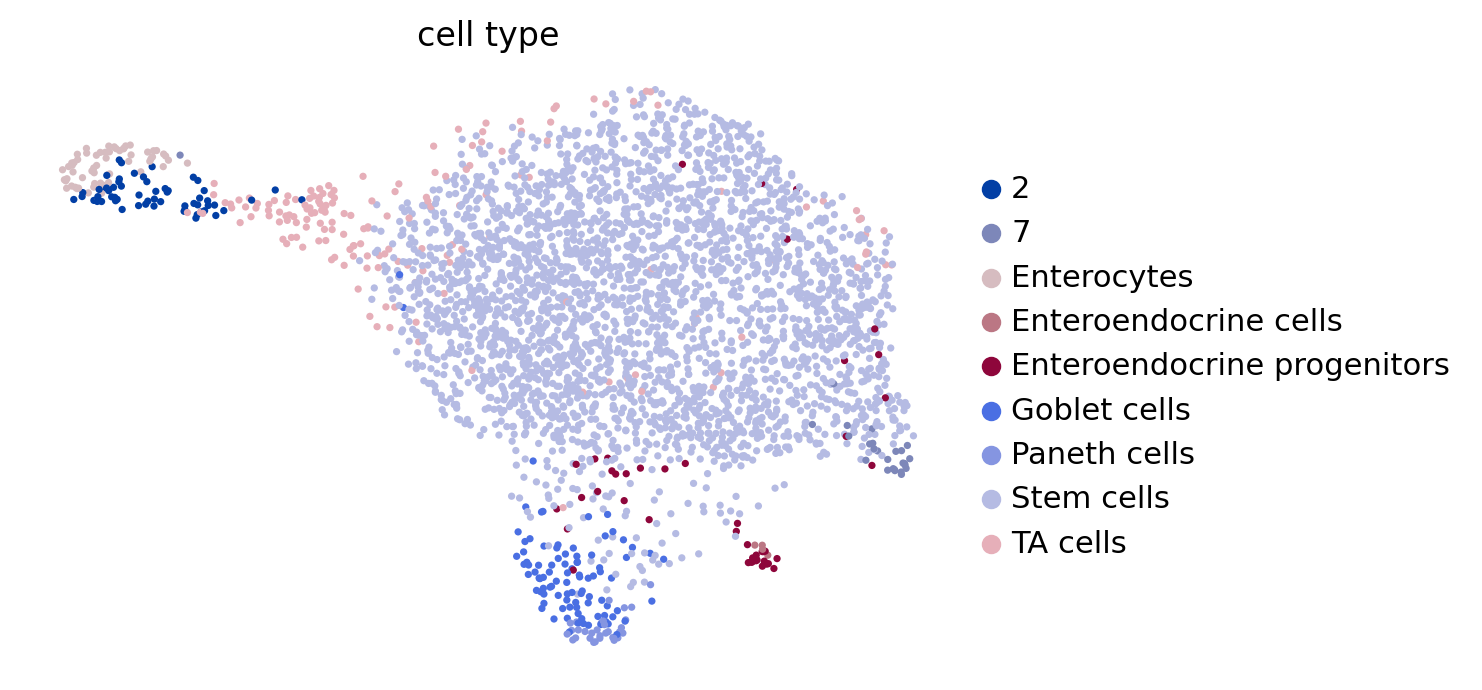

In [11]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Parameter inference

In [12]:
scv.tl.recover_dynamics(adata, n_jobs=N_JOBS)

recovering dynamics (using 8/14 cores)


  0%|          | 0/417 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


## Velocity

In [13]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## CellRank

In [14]:
vk = cr.kernels.VelocityKernel(adata, xkey="Ms", vkey="velocity").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3452 [00:00<?, ?cell/s]

Using `softmax_scale=11.9861`


  0%|          | 0/3452 [00:00<?, ?cell/s]

    Finish (0:00:02)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


## Estimator analysis

In [15]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 8, 10, 12, 14, 16, 19]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


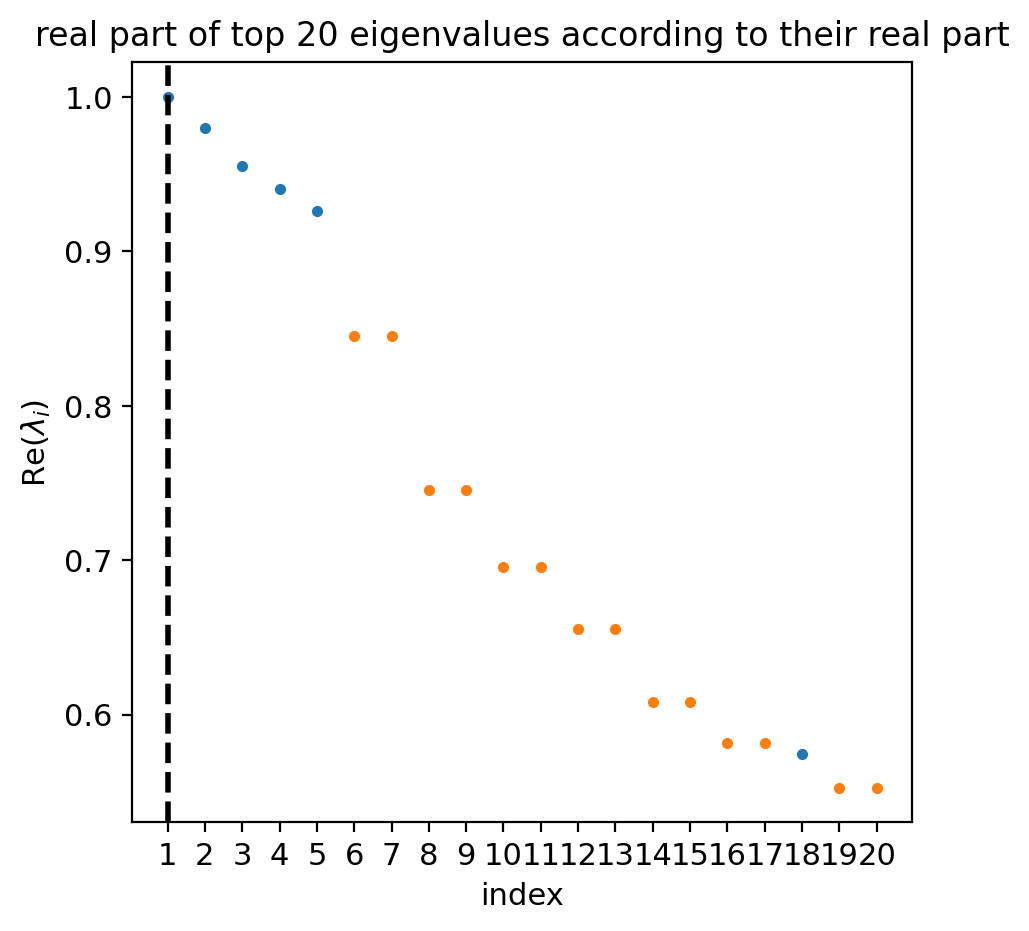

In [16]:
estimator.compute_schur(n_components=20)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)

#### Macrostates

In [17]:
terminal_states = ["Enteroendocrine progenitors", "Enterocytes", "Goblet cells", "Paneth cells"]
cluster_key = "cell_type"

if (DATA_DIR / "sceu_organoid" / "results" / "tsi-em_model.csv").is_file():
    tsi_df = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "tsi-em_model.csv")
    estimator._tsi = AnnData(tsi_df, uns={"terminal_states": terminal_states, "cluster_key": cluster_key})
    tsi_score = estimator.tsi(n_macrostates=18, terminal_states=terminal_states, cluster_key=cluster_key)
else:
    tsi_score = estimator.tsi(n_macrostates=18, terminal_states=terminal_states, cluster_key=cluster_key)
    estimator._tsi.to_df().to_csv(DATA_DIR / "sceu_organoid" / "results" / "tsi-em_model.csv", index=False)

print(f"TSI score: {tsi_score:.2f}")

TSI score: 0.71


/vol/storage/miniconda3/envs/cr2-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


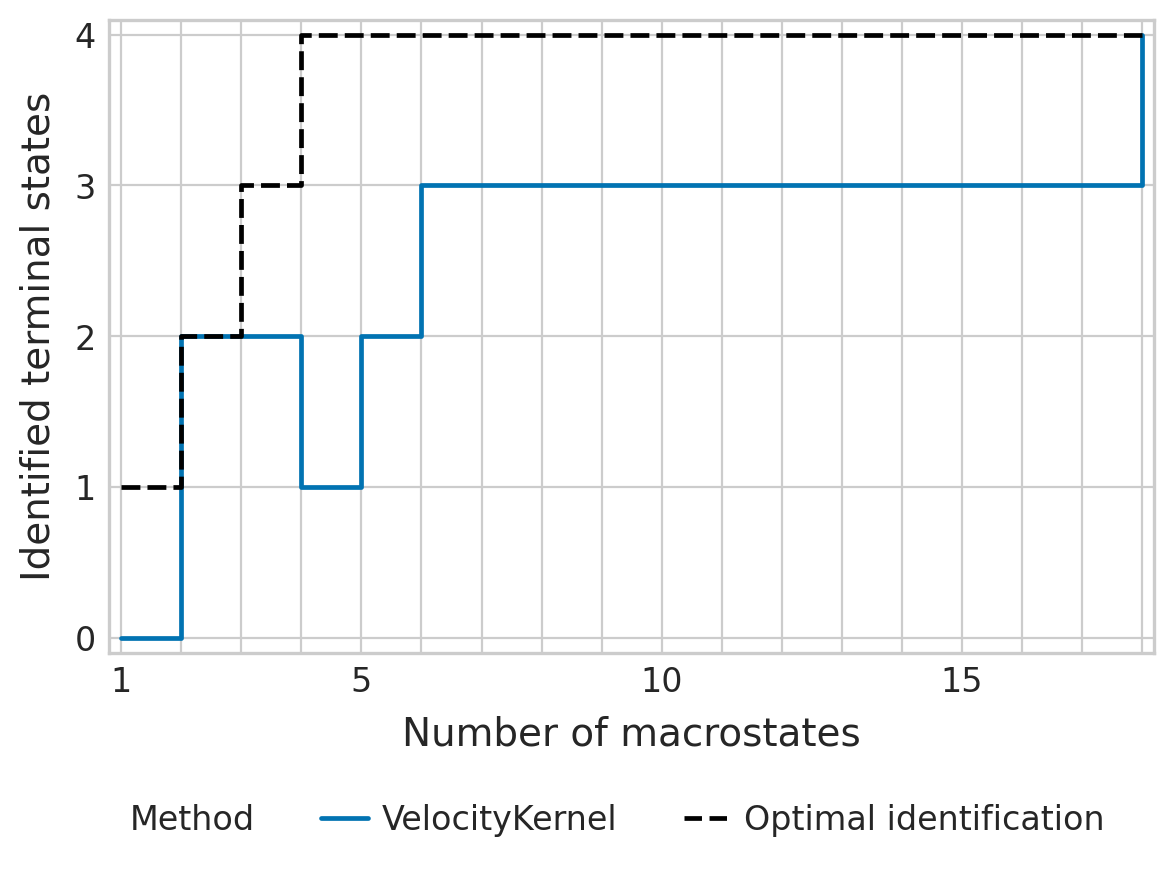

In [18]:
# For nice name in figure legend
estimator.kernel.__class__.__name__ = "VelocityKernel"
palette = {"VelocityKernel": "#0173b2", "Optimal identification": "#000000"}

if SAVE_FIGURES:
    fpath = FIG_DIR / "labeling_kernel" / f"tsi-em_model.{FIGURE_FORMAT}"
else:
    fpath = None

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    estimator.plot_tsi(palette=palette, save=fpath)
    plt.show()

Computing `18` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:14)


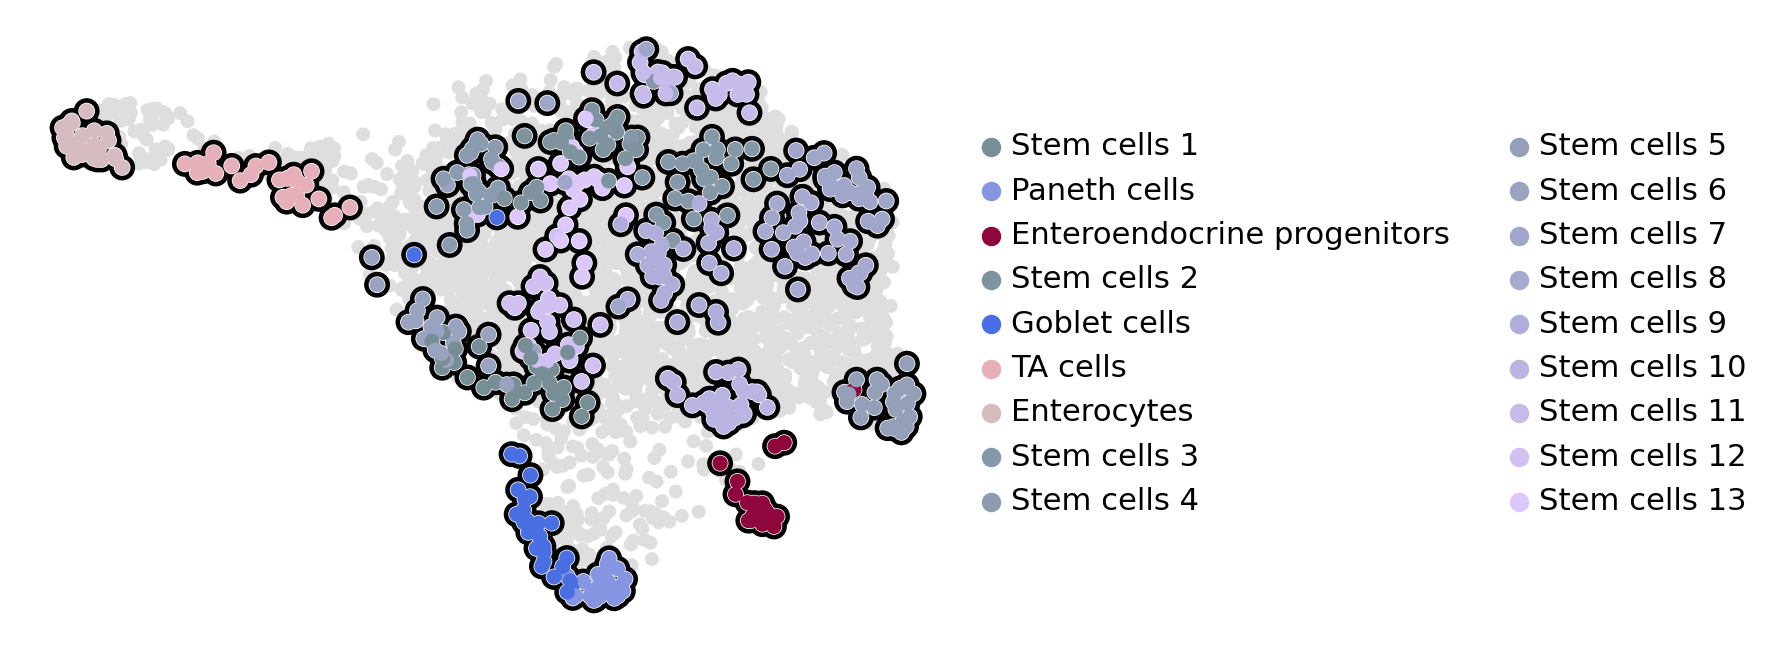

In [19]:
estimator.compute_macrostates(n_states=18, cluster_key="cell_type")
if running_in_notebook():
    estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"umap_colored_by_cr_macrostates_scvelo.{FIGURE_FORMAT}"
        estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Mean purity: 0.876984126984127


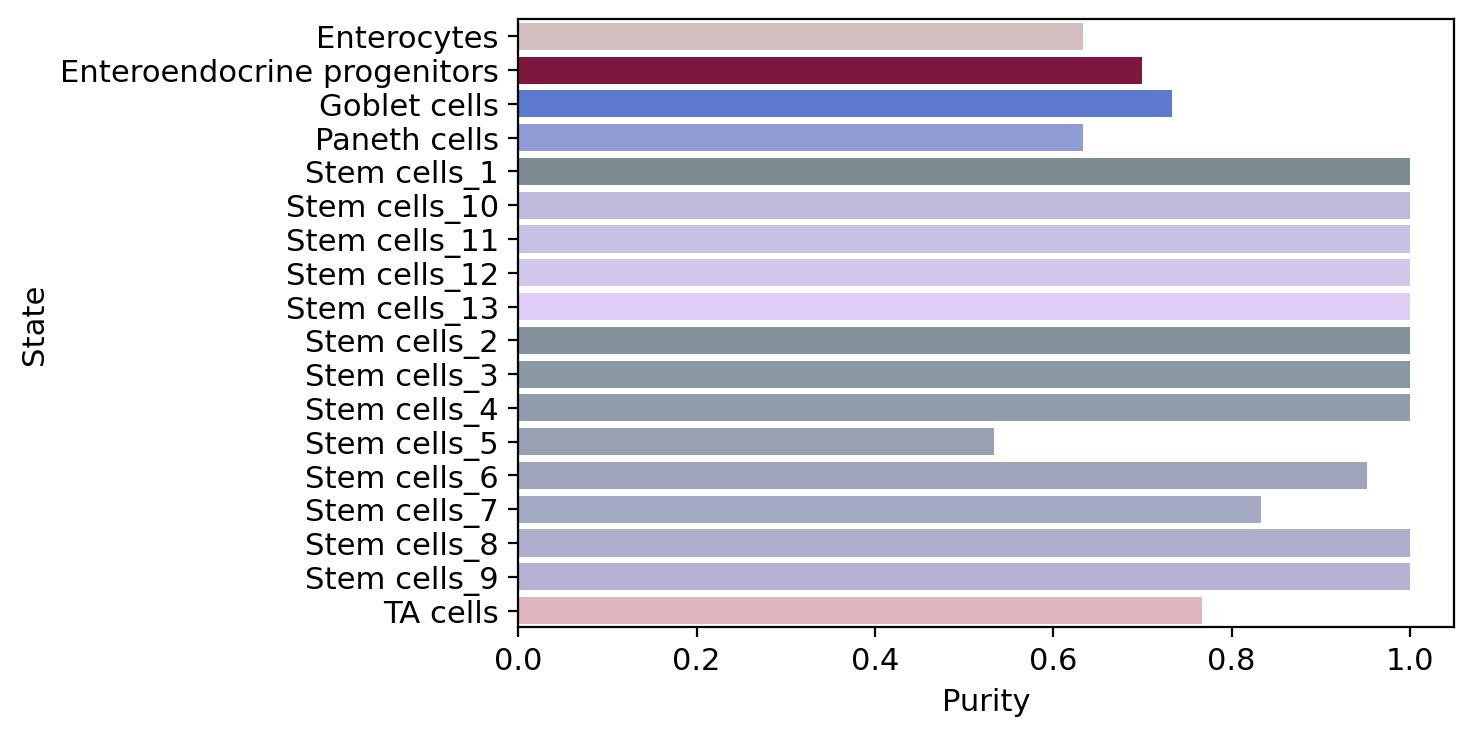

In [20]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"macrostate_purity_rna_velo.{FIGURE_FORMAT}"
    else:
        fpath = None

    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))
    order = estimator.macrostates.cat.categories.sort_values().to_list()
    plot_state_purity(macrostate_purity, palette=palette, fpath=fpath, order=order, format=FIGURE_FORMAT)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


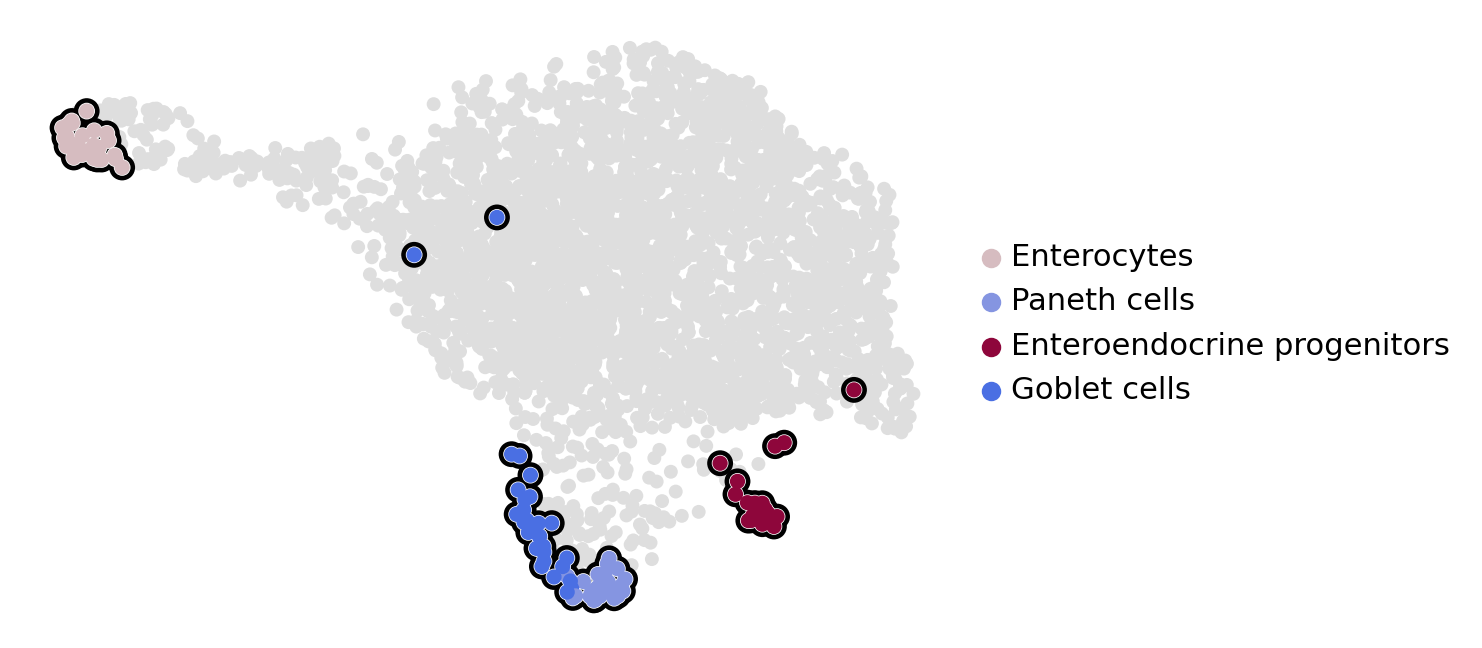

In [21]:
estimator.set_terminal_states(states=["Enterocytes", "Paneth cells", "Enteroendocrine progenitors", "Goblet cells"])

if running_in_notebook():
    estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"terminal_state_purity_scvelo.{FIGURE_FORMAT}"
        estimator.plot_macrostates(which="terminal", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Mean purity: 0.6749999999999999


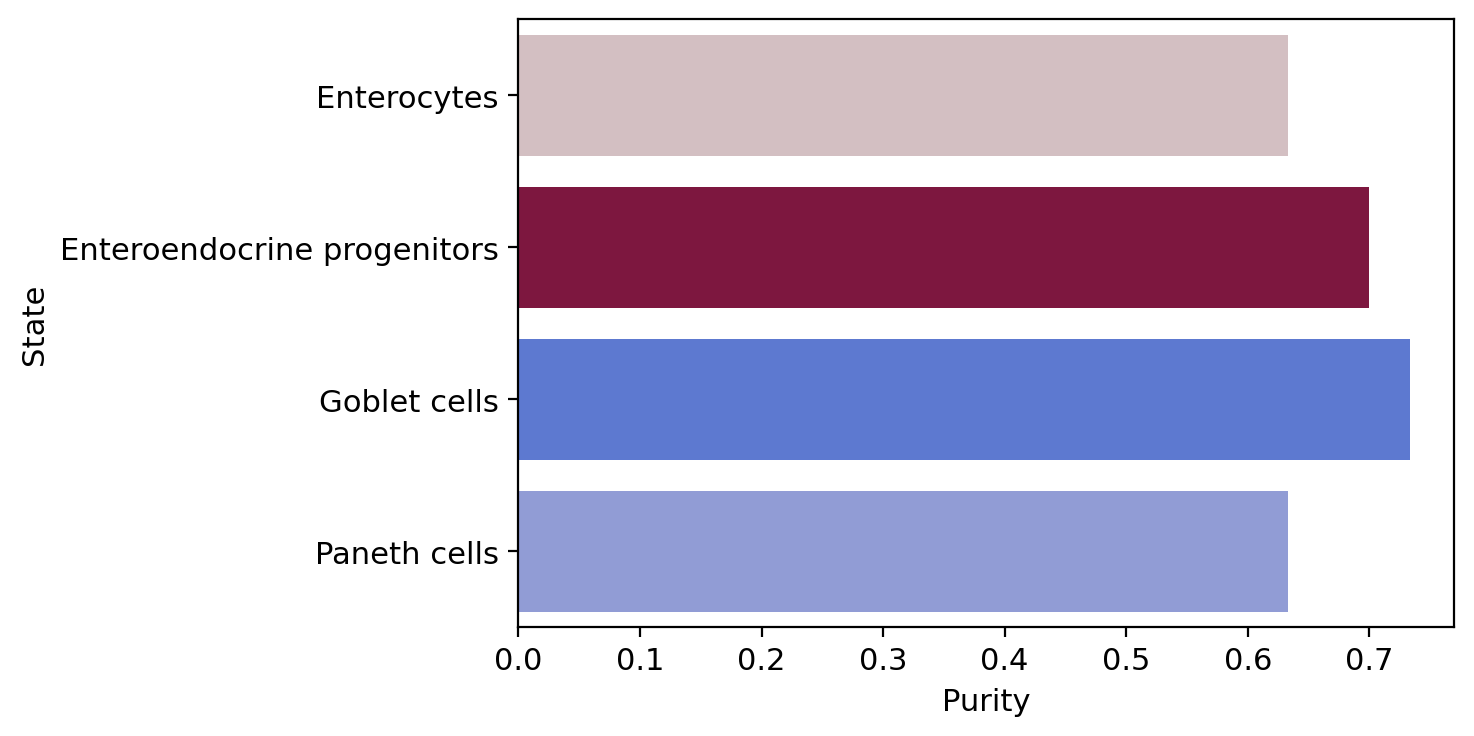

In [22]:
terminal_state_purity = get_state_purity(adata, estimator, states="terminal_states", obs_col="cell_type")
pd.DataFrame({"purity": terminal_state_purity.values(), "method": "CellRank 1"}, index=terminal_state_purity).to_csv(
    DATA_DIR / "sceu_organoid" / "results" / "terminal_state_purity_cr1.csv"
)
print(f"Mean purity: {np.mean(list(terminal_state_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / f"terminal_state_purity_rna_velo.{FIGURE_FORMAT}"
    else:
        fpath = None

    palette = dict(zip(estimator.terminal_states.cat.categories, estimator._term_states.colors))
    order = estimator.terminal_states.cat.categories.sort_values().to_list()
    plot_state_purity(terminal_state_purity, palette=palette, order=order, fpath=fpath, format=FIGURE_FORMAT)

#### Fate probabilities

In [23]:
estimator.compute_fate_probabilities()

Computing fate probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


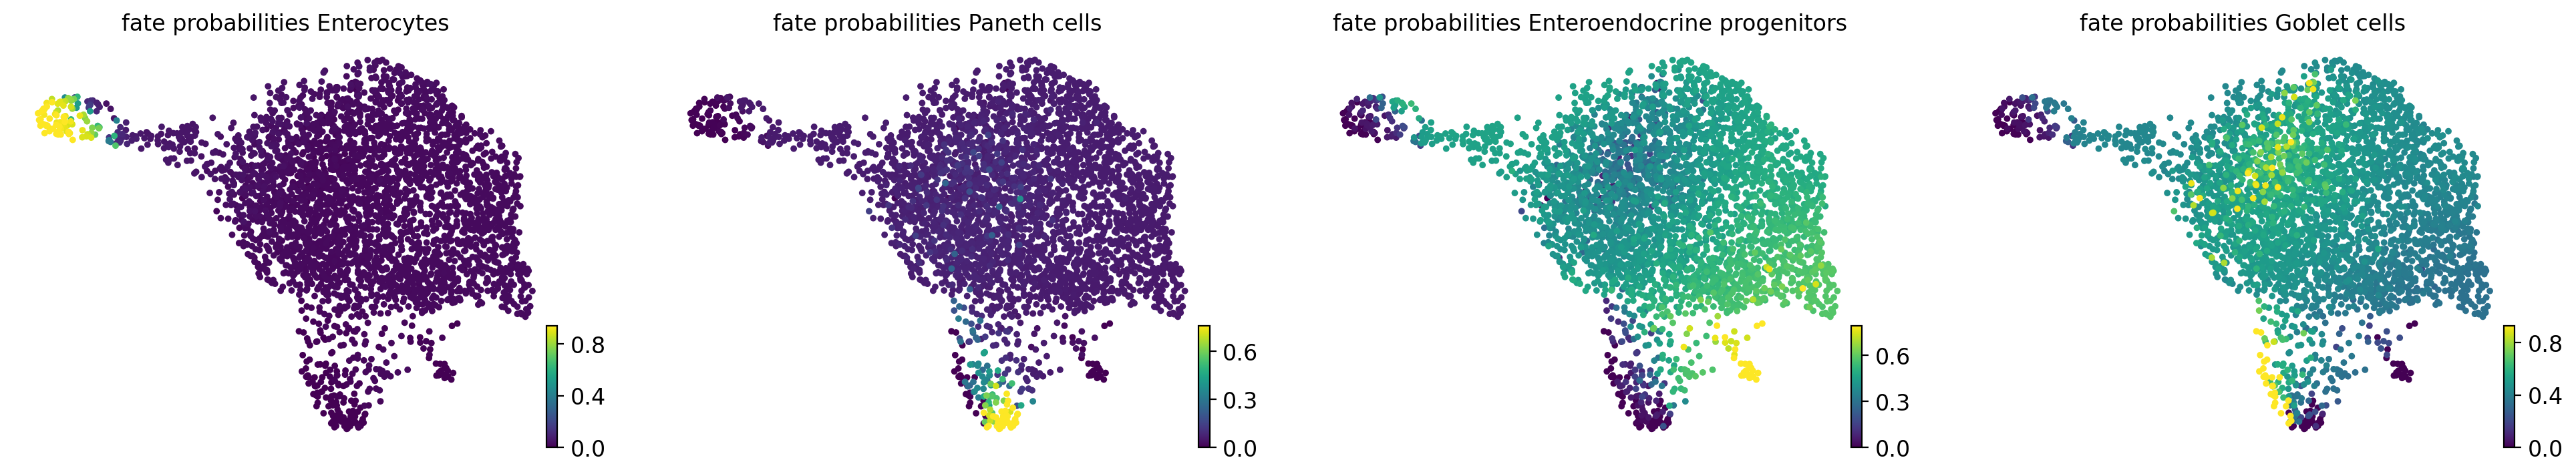

In [24]:
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, size=50, basis="umap")

### Driver analysis

In [25]:
goblet_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_markers.csv")["Gene"].str.lower().tolist()
)

goblet_markers = adata.var_names[adata.var_names.str.lower().isin(goblet_markers)]

In [26]:
goblet_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_regulators.csv")["Gene"].str.lower().tolist()
)

goblet_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_regulators)]

In [27]:
goblet_and_paneth_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_and_paneth_regulators.csv")["Gene"]
    .str.lower()
    .tolist()
)

goblet_and_paneth_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_and_paneth_regulators)]

In [28]:
paneth_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "paneth_markers.csv")["Gene"].str.lower().tolist()
)

paneth_markers = adata.var_names[adata.var_names.str.lower().isin(paneth_markers)]

In [29]:
eec_markers = pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_markers.csv")["Gene"].str.lower().tolist()

eec_markers = adata.var_names[adata.var_names.str.lower().isin(eec_markers)]

In [30]:
eec_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_progenitor_markers.csv")["Gene"].str.lower().tolist()
)

eec_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(eec_progenitor_markers)]

In [31]:
enterocyte_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_markers.csv")["Gene"].str.lower().tolist()
)

enterocyte_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_markers)]

In [32]:
enterocyte_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_progenitor_markers.csv")["Gene"]
    .str.lower()
    .tolist()
)

enterocyte_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_progenitor_markers)]

In [33]:
gene_ranks = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

In [34]:
drivers = estimator.compute_lineage_drivers(
    cluster_key="cell_type",
    lineages=["Enteroendocrine progenitors", "Goblet cells", "Paneth cells", "Enterocytes"],
    clusters=["Stem cells"],
    return_drivers=True,
)

for terminal_state in terminal_states:
    drivers = drivers.merge(
        pd.DataFrame(drivers.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


### Goblet cells

In [35]:
_df = get_var_ranks(
    var_names=goblet_markers, drivers=drivers, macrostate="Goblet cells", var_type="Marker", model="EM Model"
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Marker towards Goblet cells for EM Model in top 100: 7 (out of 95)


In [36]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Goblet cells",
    var_type="Goblet/Paneth regulator",
    model="EM Model",
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Goblet/Paneth regulator towards Goblet cells for EM Model in top 100: 0 (out of 3)


### Paneth cells

In [37]:
_df = get_var_ranks(
    var_names=paneth_markers, drivers=drivers, macrostate="Paneth cells", var_type="Marker", model="EM Model"
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Marker towards Paneth cells for EM Model in top 100: 6 (out of 18)


In [38]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Paneth cells",
    var_type="Goblet/Paneth regulator",
    model="EM Model",
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Goblet/Paneth regulator towards Paneth cells for EM Model in top 100: 0 (out of 3)


### Enteroendocrine

In [39]:
_df = get_var_ranks(
    var_names=eec_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Marker",
    model="EM Model",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Marker towards Enteroendocrine progenitors for EM Model in top 100: 12 (out of 82)


In [40]:
_df = get_var_ranks(
    var_names=eec_progenitor_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Progenitor marker",
    model="EM Model",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Progenitor marker towards Enteroendocrine progenitors for EM Model in top 100: 1 (out of 66)


### Enterocytes

In [41]:
_df = get_var_ranks(
    var_names=enterocyte_markers, drivers=drivers, macrostate="Enterocytes", var_type="Marker", model="EM Model"
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Marker towards Enterocytes for EM Model in top 100: 30 (out of 170)


In [42]:
_df = get_var_ranks(
    var_names=enterocyte_progenitor_markers,
    drivers=drivers,
    macrostate="Enterocytes",
    var_type="Progenitor marker",
    model="EM Model",
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Progenitor marker towards Enterocytes for EM Model in top 100: 11 (out of 12)


In [43]:
for terminal_state in gene_ranks.keys():
    gene_ranks[terminal_state] = gene_ranks[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    gene_ranks[terminal_state].to_csv(
        DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_{terminal_state}-em_model.csv"
    )